In [1]:
import pandas as pd
import numpy as np
import torch, torch.nn
#from transformers import BertModel, BertTokenizer, pipeline
import re, gc, os
import requests
from tqdm.auto import tqdm
import __init__

/z/home/sgal/miniconda3/envs/thermoPML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from src.ESM2embeddings import ESM2embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader
from src.NeuralArchitectures import regressionHead
from src.Trainer import Trainer


path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
dir_pre_generated_embeddings = '../prepro_embeddings/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ESM2.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ESM2.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ESM2.pth'


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#BERT = ESM2embeddings(type_embedding = "facebook/esm2_t6_8M_UR50D", device = device)
Trainer = Trainer()

splits_meltome = pd.read_csv(path_meltome, sep=',')
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
splits_meltome['sequence']=splits_meltome['sequence']
train, val, test = train_test_validation_splits(splits_meltome)

In [3]:
import torch
import esm


# Load ESM-2 model
"""
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D() #esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model = model.to(device)

if torch.cuda.is_available() and device!='cpu':
    model = model.half()
model.eval()  # disables dropout for deterministic results
"""
pt_batch_size = 16

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

"""
def truncate(sequences, length):
    '''Function to truncate protein sequences at a given length'''
    num_truncated = len([seq for seq in sequences if len(seq) > length])
    print(num_truncated, 'sequences were too long and have been truncated to', length, 'AA')
    sequences = [seq[:length] for seq in sequences]
    
    return sequences

def esm2embedding(all_data, model, batch_converter, device, truncate_length=1000, layer_index=6):
    
    embeddings = torch.tensor([]).to(device)
    all_data.sequence = truncate(all_data.sequence.values, truncate_length)
    
    for i in tqdm(range(0,len(all_data), pt_batch_size)):
        batch = all_data.iloc[i:i+pt_batch_size]

        esm_data = list(zip(batch.index, batch.sequence))
        batch_labels, batch_strs, batch_tokens = batch_converter(esm_data)
        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        
        batch_tokens = batch_tokens.to(device)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[layer_index])
        token_embeddings = results["representations"][layer_index]
        
        # Generate per-sequence representations via averaging
        # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
        for i, tokens_len in enumerate(batch_lens):
            sequence_embeddings = token_embeddings[i, 1 : tokens_len - 1].mean(0).reshape(1,-1)
            embeddings = torch.cat([embeddings, sequence_embeddings])
        
        torch.cuda.empty_cache()
                
    return embeddings
"""




'\ndef truncate(sequences, length):\n    \'\'\'Function to truncate protein sequences at a given length\'\'\'\n    num_truncated = len([seq for seq in sequences if len(seq) > length])\n    print(num_truncated, \'sequences were too long and have been truncated to\', length, \'AA\')\n    sequences = [seq[:length] for seq in sequences]\n    \n    return sequences\n\ndef esm2embedding(all_data, model, batch_converter, device, truncate_length=1000, layer_index=6):\n    \n    embeddings = torch.tensor([]).to(device)\n    all_data.sequence = truncate(all_data.sequence.values, truncate_length)\n    \n    for i in tqdm(range(0,len(all_data), pt_batch_size)):\n        batch = all_data.iloc[i:i+pt_batch_size]\n\n        esm_data = list(zip(batch.index, batch.sequence))\n        batch_labels, batch_strs, batch_tokens = batch_converter(esm_data)\n        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)\n\n        \n        batch_tokens = batch_tokens.to(device)\n\n        with torch.no_gr

In [4]:
if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:

    """batch_train, batch_test, batch_val = prepare_train_test_val_seqs_by_batches(train.sequence.to_list(), 
                                                                                test.sequence.to_list(), 
                                                                                val.sequence.to_list(), 
                                                                                batch_size=2)"""
    print ("Creating Embeddings...")   
    train_embeddings = ESM2.esm2embedding(train, device, layer_index=33) #esm2embedding(train, model, batch_converter, device, layer_index=33)#BERT.embed_dataset(batch_train)
    torch.save(train_embeddings, path_train)
    test_embeddings = ESM2.esm2embedding(test, device, layer_index=33) #esm2embedding(test, model, batch_converter, device, layer_index=33)
    torch.save(test_embeddings, path_test)
    val_embeddings = ESM2.esm2embedding(val, device, layer_index=33) #esm2embedding(val, model, batch_converter, device, layer_index=33)
    torch.save(val_embeddings, path_val)
    print ("Loaded")
else:
    print ("Loading Premade Embeddings...")
    train_embeddings = torch.load(path_train)
    test_embeddings = torch.load(path_test)
    val_embeddings = torch.load(path_val)
    print ("Loaded")
    
train_loader = tensor2dataloader(train_embeddings, torch.from_numpy( train.target.to_numpy() ), batch_size=50)
test_loader = tensor2dataloader(test_embeddings, torch.from_numpy( test.target.to_numpy() ), batch_size=50)
val_loader = tensor2dataloader(val_embeddings, torch.from_numpy( val.target.to_numpy() ), batch_size=50)

Loading Premade Embeddings...
Loaded


In [5]:
model = regressionHead(train_embeddings.shape[1::])
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss= torch.nn.MSELoss()
epochs = 200
model, val_loss = Trainer.train_LLMRegresor(train_loader, val_loader, model, device, loss, opt, epochs)

epoch: 1 loss: 1487.603 val loss: 1136.750


epoch: 2 loss: 416.646 val loss: 522.100


epoch: 3 loss: 213.059 val loss: 243.122


epoch: 4 loss: 97.611 val loss: 140.660


epoch: 5 loss: 140.626 val loss: 117.847


epoch: 6 loss: 128.487 val loss: 113.422


epoch: 7 loss: 199.040 val loss: 112.723


epoch: 8 loss: 155.410 val loss: 112.738


epoch: 9 loss: 168.709 val loss: 113.511


epoch: 10 loss: 56.757 val loss: 112.641


epoch: 11 loss: 102.802 val loss: 112.469


epoch: 12 loss: 40.721 val loss: 91.837


epoch: 13 loss: 70.747 val loss: 69.987


epoch: 14 loss: 27.640 val loss: 56.861


epoch: 15 loss: 45.493 val loss: 49.906


epoch: 16 loss: 37.280 val loss: 45.493


epoch: 17 loss: 46.790 val loss: 43.343


epoch: 18 loss: 30.209 val loss: 41.807


epoch: 19 loss: 56.448 val loss: 41.478


epoch: 20 loss: 68.643 val loss: 41.068


epoch: 21 loss: 40.611 val loss: 40.288


epoch: 22 loss: 32.205 val loss: 40.231


epoch: 23 loss: 32.795 val loss: 39.680


epoch: 24 loss: 28.428 val loss: 39.432


epoch: 25 loss: 35.664 val loss: 39.448


epoch: 26 loss: 31.403 val loss: 39.216


epoch: 27 loss: 34.232 val loss: 39.551


epoch: 28 loss: 30.776 val loss: 38.803


epoch: 29 loss: 26.455 val loss: 38.708


epoch: 30 loss: 26.796 val loss: 38.551


epoch: 31 loss: 47.948 val loss: 38.592


epoch: 32 loss: 60.035 val loss: 38.347


epoch: 33 loss: 54.493 val loss: 37.949


epoch: 34 loss: 50.453 val loss: 37.951


epoch: 35 loss: 38.042 val loss: 37.851


epoch: 36 loss: 26.554 val loss: 37.618


epoch: 37 loss: 22.157 val loss: 37.597


epoch: 38 loss: 30.043 val loss: 37.555


epoch: 39 loss: 37.369 val loss: 37.165


epoch: 40 loss: 25.004 val loss: 37.224


epoch: 41 loss: 26.710 val loss: 37.648


epoch: 42 loss: 33.065 val loss: 37.044


epoch: 43 loss: 33.084 val loss: 37.031


epoch: 44 loss: 32.020 val loss: 37.063


epoch: 45 loss: 36.671 val loss: 36.803


epoch: 46 loss: 19.023 val loss: 37.193


epoch: 47 loss: 26.361 val loss: 37.442


epoch: 48 loss: 11.685 val loss: 37.164


epoch: 49 loss: 39.423 val loss: 36.884


epoch: 50 loss: 27.280 val loss: 37.692


epoch: 51 loss: 47.317 val loss: 36.614


epoch: 52 loss: 41.360 val loss: 36.871


epoch: 53 loss: 39.218 val loss: 36.567


epoch: 54 loss: 48.675 val loss: 36.415


epoch: 55 loss: 39.225 val loss: 36.598


epoch: 56 loss: 69.579 val loss: 36.413


epoch: 57 loss: 44.364 val loss: 36.695


epoch: 58 loss: 41.579 val loss: 36.890


epoch: 59 loss: 38.616 val loss: 36.388


epoch: 60 loss: 18.437 val loss: 36.602


epoch: 61 loss: 24.984 val loss: 36.602


epoch: 62 loss: 16.530 val loss: 36.302


epoch: 63 loss: 38.954 val loss: 36.216


epoch: 64 loss: 29.498 val loss: 36.308


epoch: 65 loss: 33.080 val loss: 36.283


epoch: 66 loss: 29.979 val loss: 36.544


epoch: 67 loss: 48.133 val loss: 36.196


epoch: 68 loss: 26.003 val loss: 36.303


epoch: 69 loss: 25.043 val loss: 36.096


epoch: 70 loss: 29.691 val loss: 36.176


epoch: 71 loss: 41.782 val loss: 36.137


epoch: 72 loss: 29.724 val loss: 36.053


epoch: 73 loss: 24.697 val loss: 36.224


epoch: 74 loss: 30.374 val loss: 36.139


epoch: 75 loss: 25.420 val loss: 36.162


epoch: 76 loss: 27.457 val loss: 36.106


epoch: 77 loss: 21.148 val loss: 36.301


epoch: 78 loss: 36.373 val loss: 36.061


epoch: 79 loss: 29.633 val loss: 35.981


epoch: 80 loss: 36.674 val loss: 36.060


epoch: 81 loss: 50.419 val loss: 36.006


epoch: 82 loss: 20.002 val loss: 36.236


epoch: 83 loss: 47.216 val loss: 36.147


epoch: 84 loss: 16.255 val loss: 35.987


epoch: 85 loss: 21.648 val loss: 36.156


epoch: 86 loss: 37.080 val loss: 36.479


epoch: 87 loss: 25.110 val loss: 36.443


epoch: 88 loss: 20.776 val loss: 36.852


epoch: 89 loss: 28.430 val loss: 36.041


epoch: 90 loss: 32.406 val loss: 36.268


epoch: 91 loss: 26.574 val loss: 36.408


epoch: 92 loss: 23.285 val loss: 36.004


epoch: 93 loss: 26.154 val loss: 36.006


epoch: 94 loss: 20.264 val loss: 36.161


epoch: 95 loss: 18.556 val loss: 36.196


epoch: 96 loss: 21.286 val loss: 35.811


epoch: 97 loss: 32.926 val loss: 36.095


epoch: 98 loss: 16.337 val loss: 36.456


epoch: 99 loss: 28.958 val loss: 36.023


epoch: 100 loss: 55.206 val loss: 37.467


epoch: 101 loss: 25.294 val loss: 36.407


epoch: 102 loss: 26.377 val loss: 35.797


epoch: 103 loss: 25.897 val loss: 36.070


epoch: 104 loss: 19.557 val loss: 36.026


epoch: 105 loss: 41.069 val loss: 35.911


epoch: 106 loss: 24.289 val loss: 35.978


epoch: 107 loss: 31.740 val loss: 36.009


epoch: 108 loss: 43.942 val loss: 36.204


epoch: 109 loss: 35.091 val loss: 35.929


epoch: 110 loss: 22.100 val loss: 36.026


epoch: 111 loss: 16.785 val loss: 36.139


epoch: 112 loss: 30.107 val loss: 36.043


epoch: 113 loss: 38.935 val loss: 37.108


epoch: 114 loss: 24.520 val loss: 36.439


epoch: 115 loss: 18.368 val loss: 36.310


epoch: 116 loss: 24.251 val loss: 36.262


epoch: 117 loss: 17.455 val loss: 35.658


epoch: 118 loss: 31.906 val loss: 35.951


epoch: 119 loss: 18.803 val loss: 36.169


epoch: 120 loss: 14.465 val loss: 36.030


epoch: 121 loss: 28.247 val loss: 35.847


epoch: 122 loss: 20.800 val loss: 36.161


epoch: 123 loss: 27.897 val loss: 36.326


epoch: 124 loss: 25.549 val loss: 35.998


epoch: 125 loss: 35.799 val loss: 35.944


epoch: 126 loss: 40.664 val loss: 36.219


epoch: 127 loss: 22.983 val loss: 36.187


epoch: 128 loss: 22.265 val loss: 35.751


epoch: 129 loss: 26.521 val loss: 35.723


epoch: 130 loss: 21.137 val loss: 36.146


epoch: 131 loss: 37.427 val loss: 35.686


epoch: 132 loss: 32.698 val loss: 35.853


epoch: 133 loss: 13.449 val loss: 36.043


epoch: 134 loss: 14.807 val loss: 35.635


epoch: 135 loss: 29.804 val loss: 35.788


epoch: 136 loss: 21.598 val loss: 35.687


epoch: 137 loss: 22.546 val loss: 35.674


epoch: 138 loss: 19.188 val loss: 35.926


epoch: 139 loss: 18.271 val loss: 35.829


epoch: 140 loss: 26.614 val loss: 35.777


epoch: 141 loss: 21.722 val loss: 35.680


epoch: 142 loss: 16.190 val loss: 35.765


epoch: 143 loss: 27.982 val loss: 36.284


epoch: 144 loss: 39.441 val loss: 36.430


epoch: 145 loss: 18.488 val loss: 35.716


epoch: 146 loss: 34.308 val loss: 36.770


epoch: 147 loss: 30.804 val loss: 35.638


epoch: 148 loss: 26.974 val loss: 35.611


epoch: 149 loss: 36.141 val loss: 36.300


epoch: 150 loss: 23.602 val loss: 35.616


epoch: 151 loss: 19.077 val loss: 35.755


epoch: 152 loss: 28.334 val loss: 35.937


epoch: 153 loss: 31.788 val loss: 36.291


epoch: 154 loss: 19.234 val loss: 35.687


epoch: 155 loss: 21.334 val loss: 35.673


epoch: 156 loss: 36.427 val loss: 36.785


epoch: 157 loss: 20.701 val loss: 35.836


epoch: 158 loss: 37.270 val loss: 35.894


epoch: 159 loss: 19.061 val loss: 35.842


epoch: 160 loss: 26.391 val loss: 35.860


epoch: 161 loss: 33.311 val loss: 36.283


epoch: 162 loss: 25.567 val loss: 36.047


epoch: 163 loss: 25.053 val loss: 35.773


epoch: 164 loss: 43.163 val loss: 36.289


epoch: 165 loss: 27.452 val loss: 35.716


epoch: 166 loss: 28.800 val loss: 35.662


epoch: 167 loss: 28.366 val loss: 36.059


epoch: 168 loss: 24.923 val loss: 37.069


epoch: 169 loss: 15.817 val loss: 35.716


epoch: 170 loss: 41.790 val loss: 35.854


epoch: 171 loss: 25.135 val loss: 35.497


epoch: 172 loss: 27.092 val loss: 35.813


epoch: 173 loss: 25.861 val loss: 36.130


epoch: 174 loss: 40.431 val loss: 35.849


epoch: 175 loss: 10.194 val loss: 36.550


epoch: 176 loss: 24.593 val loss: 35.881


epoch: 177 loss: 22.603 val loss: 37.318


epoch: 178 loss: 20.870 val loss: 35.716


epoch: 179 loss: 21.664 val loss: 35.598


epoch: 180 loss: 13.858 val loss: 36.395


epoch: 181 loss: 37.884 val loss: 35.721


epoch: 182 loss: 30.148 val loss: 35.673


epoch: 183 loss: 18.023 val loss: 35.518


epoch: 184 loss: 25.732 val loss: 35.740


epoch: 185 loss: 21.624 val loss: 35.566


epoch: 186 loss: 37.575 val loss: 35.760


epoch: 187 loss: 17.702 val loss: 35.717


epoch: 188 loss: 27.860 val loss: 36.138


epoch: 189 loss: 29.674 val loss: 36.712


epoch: 190 loss: 12.767 val loss: 35.835


epoch: 191 loss: 23.860 val loss: 36.217


epoch: 192 loss: 15.768 val loss: 35.710


epoch: 193 loss: 33.563 val loss: 35.509


epoch: 194 loss: 25.137 val loss: 36.024


epoch: 195 loss: 22.214 val loss: 35.759


epoch: 196 loss: 24.246 val loss: 36.036


epoch: 197 loss: 22.556 val loss: 35.620


epoch: 198 loss: 37.778 val loss: 36.142


epoch: 199 loss: 29.698 val loss: 35.922


epoch: 200 loss: 18.437 val loss: 35.739


MSE: tensor(38.4109, device='cuda:0', grad_fn=<MseLossBackward0>)
RMSE: tensor(6.1977, device='cuda:0', grad_fn=<SqrtBackward0>)
MAE: tensor(2.1195, device='cuda:0', grad_fn=<SqrtBackward0>)


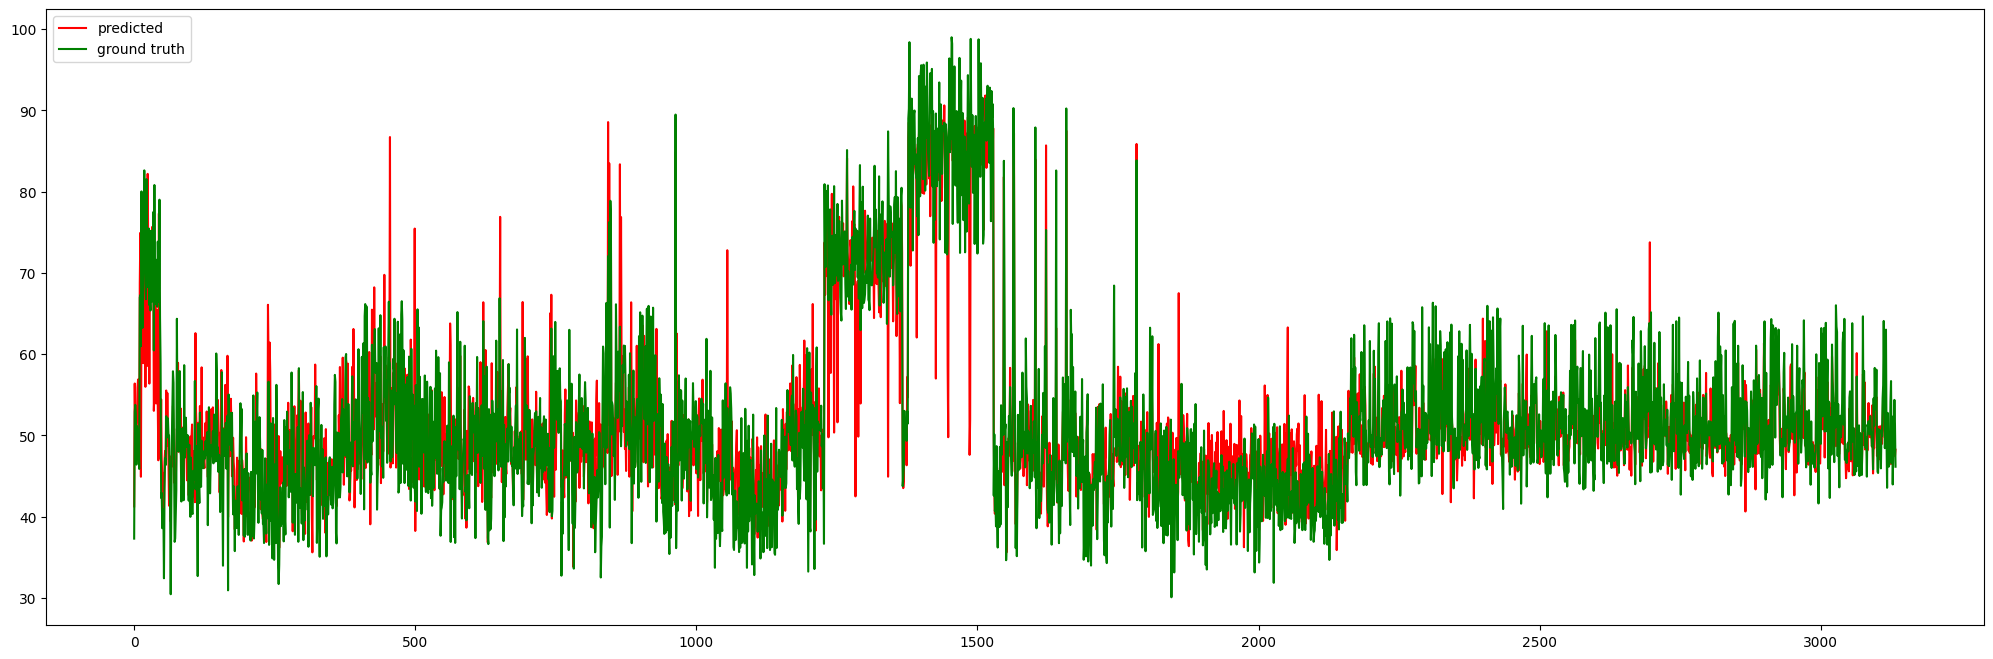

In [6]:
test_set, test_labels = test_loader.dataset.tensors
loss_test, outcome = Trainer.test_model(model, test_set, test_labels, loss, device)
from src.utilities import plot_results

plot_results( outcome, test_labels) 